In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### 获取数据集

我们使用的热狗数据集来源于网络。 该数据集包含1400张热狗的“正类”图像，以及包含尽可能多的其他食物的“负类”图像。 含着两个类别的1000张图片用于训练，其余的则用于测试。

解压下载的数据集，我们获得了两个文件夹hotdog/train和hotdog/test。 这两个文件夹都有hotdog（有热狗）和not-hotdog（无热狗）两个子文件夹， 子文件夹内都包含相应类的图像。

In [2]:
# @save
d2l.DATA_HUB["hotdog"] = (
    d2l.DATA_URL + "hotdog.zip",
    "fba480ffa8aa7e0febbb511d181409f899b9baa5",
)

data_dir = d2l.download_extract("hotdog")


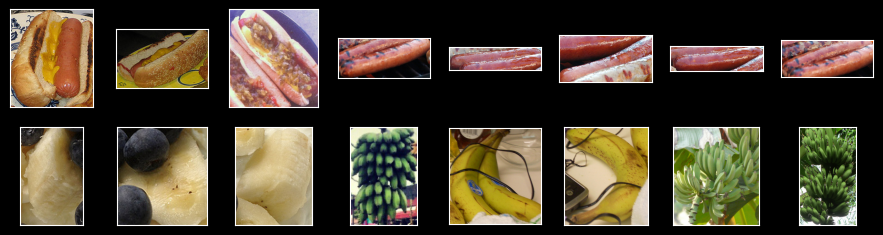

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, "test"))
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);


首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为224x224
输入图像。 在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央224x224区域作为输入。 此外，对于RGB（红、绿和蓝）颜色通道，我们分别标准化每个通道。 具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。

In [4]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)

train_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)

test_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize([256, 256]),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)


### 定义和初始化模型

我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。 在这里，我们指定pretrained=True以自动下载预训练的模型参数。 如果首次使用此模型，则需要连接互联网才能下载。

In [5]:
pretrained_net = torchvision.models.resnet18(pretrained=True)


/home/ivansnow02/deep_learning/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ivansnow02/deep_learning/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ivansnow02/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [6]:
pretrained_net.fc


Linear(in_features=512, out_features=1000, bias=True)

将最后的全连接层替换为一个新的全连接层。 该层的输入大小为512（ResNet-18的输出大小），输出大小为2（热狗和非热狗）。

成员变量output的参数是随机初始化的，通常需要更高的学习率才能从头开始训练。 假设Trainer实例中的学习率为
，我们将成员变量output中参数的学习率设置为
。

In [38]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)


Parameter containing:
tensor([[ 0.0260,  0.0577,  0.0095,  ...,  0.0538, -0.0820,  0.0881],
        [ 0.0668,  0.0667, -0.0040,  ..., -0.0246, -0.0951, -0.0294]],
       requires_grad=True)

### 微调模型



In [39]:
def train_fine_tuning(
    net, learning_rate, batch_size=128, num_epochs=5, param_group=True
):
    """Train the fine-tuning model.

    Args:
        net: pretrained model
        learning_rate: learning rate for the optimizer
        batch_size (int, optional): size of the batches. Defaults to 128.
        num_epochs (int, optional): number of epochs to train. Defaults to 5.
        param_group (bool, optional): whether to use parameter groups. Defaults to True. If param_group is True, learning rate will be 10x
    """
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, "train"), transform=train_augs
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, "test"), transform=test_augs
        ),
        batch_size=batch_size,
        shuffle=False,
    )

    device = d2l.try_all_gpus()


    loss = nn.CrossEntropyLoss(reduction="none")

    if param_group:
        params_1x = [
            param
            for name, param in net.named_parameters()
            if name not in ["fc.weight", "fc.bias"]
        ]
        trainer = torch.optim.SGD(
            [
                {"params": params_1x},
                {"params": net.fc.parameters(), "lr": learning_rate * 10},
            ],
            lr=learning_rate,
            weight_decay=0.001
        )
    else:
        trainer = torch.optim.SGD(
            net.parameters(), lr=learning_rate, weight_decay=0.001
        )
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, device)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

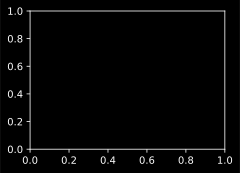

In [35]:
train_fine_tuning(finetune_net, 5e-5)

In [31]:
from PIL import Image
# test the pretrained model
# load ./image.png
test_img = Image.open("./image copy.png")

transformed_img = test_augs(test_img)


In [32]:
print(test_img)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=92x92 at 0x7F9BFC81B510>


In [33]:

finetune_net.eval()

def predict(net, test_img):
    """Predict the class of the image.

    Args:
        net: pretrained model
        test_img: image to be predicted
    """
    test_img = test_img.unsqueeze(0)
    test_img = test_img.to(d2l.try_gpu())
    pred = net(test_img)
    pred = torch.argmax(pred, dim=1)
    return pred.item()
pred = predict(finetune_net, transformed_img)
if pred == 0:
    print("This is a hotdog!")
else:
    print("This is not a hotdog!")

This is not a hotdog!


### 冻结除输出层外的所有参数

将输出层finetune_net之前的参数设置为源模型的参数，在训练期间不要更新它们。模型的准确性如何变化？

**会下降。**

现在我们将除输出层外的所有参数冻结，这样在训练期间只有输出层的参数会被更新。这种方法被称为特征提取（feature extraction），因为预训练模型的主体部分仅用于提取特征，而不进行更新。

In [40]:
# 创建一个新的模型实例进行实验
frozen_net = torchvision.models.resnet18(pretrained=True)
frozen_net.fc = nn.Linear(frozen_net.fc.in_features, 2)
nn.init.xavier_uniform_(frozen_net.fc.weight)

# 冻结除fc层外的所有参数
for param in frozen_net.parameters():
    param.requires_grad = False

# 解冻fc层参数
for param in frozen_net.fc.parameters():
    param.requires_grad = True

# 验证只有fc层参数可训练
for name, param in frozen_net.named_parameters():
    print(f"{name}: {param.requires_grad}")

conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
layer2.0.bn2.weight: False
layer2.0.bn2.bias: False
layer2.0.downsample.0.weight: False
layer2.0.downsample.1.weight: False
layer2.0.downsample.1.bias: False
layer2.1.conv1.weight: False
layer2.1.bn1.weight: False
layer2.1.bn1.bias: False
layer2.1.conv2.weight: False
layer2.1.bn2.weight: False
layer2.1.bn2.bias: False
layer3.0.conv1.weight: False
layer3.0.bn1.weight: False
layer3.0.bn1.bias: False
layer3.0.conv2.weight: False
layer3.0.bn2.weight: False
layer3.0.bn2.bias: False
layer3.0.downsample.0.weight: 

loss 2.222, train acc 0.901, test acc 0.835
1356.8 examples/sec on [device(type='cuda', index=0)]


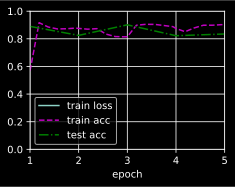

In [41]:
# 训练冻结模型
train_fine_tuning(frozen_net, 5e-4)

In [42]:
pred = predict(frozen_net, transformed_img)

if pred == 0:
    print("This is a hotdog!")
else:
    print("This is not a hotdog!")

This is not a hotdog!


### 利用预训练模型的参数（热狗）


In [43]:
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape


torch.Size([1, 512])

In [48]:
hotdog_net = torchvision.models.resnet18(pretrained=True)
hotdog_net.fc = nn.Linear(hotdog_net.fc.in_features, 2)

# 初始化新的全连接层的权重
nn.init.xavier_uniform_(finetune_net.fc.weight)

# 将“热狗”类别的权重参数应用到新的模型中
finetune_net.fc.weight.data[0] = hotdog_w

# for param in hotdog_net.parameters():
#     param.requires_grad = False

# for param in hotdog_net.fc.parameters():
#     param.requires_grad = True


loss 0.219, train acc 0.925, test acc 0.917
454.4 examples/sec on [device(type='cuda', index=0)]


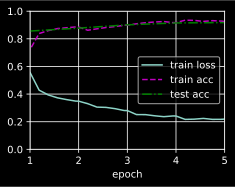

In [49]:
train_fine_tuning(hotdog_net, 5e-5, param_group=False)

In [50]:
pred = predict(hotdog_net, transformed_img)

if pred == 0:
    print("This is a hotdog!")
else:
    print("This is not a hotdog!")

This is not a hotdog!
